In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

from sklearn import preprocessing
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # use Seaborn styles
sns.color_palette("Blues")

plt.style.use('fivethirtyeight')

from sklearn.metrics import accuracy_score


import warnings; warnings.simplefilter('ignore')


['test.csv', 'train.csv', 'gender_submission.csv']


In [2]:
train = pd.read_csv('../input/train.csv', index_col='PassengerId')
test = pd.read_csv('../input/test.csv', index_col='PassengerId')
sample_submission = pd.read_csv('../input/gender_submission.csv', index_col='PassengerId')

In [3]:
print('The train data has the following dimensions: {}'.format(train.shape))

print('Meanwhile, the test data has the following dimensions: {}'.format(test.shape))

The train data has the following dimensions: (891, 11)
Meanwhile, the test data has the following dimensions: (418, 10)


# EDA

Allows to understand the data better. This helps building an intuition about the data which will eventually help to create new features, new hypothesis and obtain a better score.

Visualization plays an important role in this process.

In [4]:
train.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,C
380,0,3,"Gustafsson, Mr. Karl Gideon",male,19.0,0,0,347069,7.7750,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
448,1,1,"Seward, Mr. Frederic Kimber",male,34.0,0,0,113794,26.5500,NaN,S
176,0,3,"Klasen, Mr. Klas Albin",male,18.0,1,1,350404,7.8542,NaN,S


In [5]:
test.sample(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1210,3,"Jonsson, Mr. Nils Hilding",male,27.0,0,0,350408,7.8542,NaN,S
1255,3,"Strilic, Mr. Ivan",male,27.0,0,0,315083,8.6625,NaN,S
1183,3,"Daly, Miss. Margaret Marcella Maggie""""",female,30.0,0,0,382650,6.9500,NaN,Q
1098,3,"McGowan, Miss. Katherine",female,35.0,0,0,9232,7.7500,NaN,Q
1289,1,"Frolicher-Stehli, Mrs. Maxmillian (Margaretha ...",female,48.0,1,1,13567,79.2000,B41,C


# EDA. Comparing train-test sets

In [6]:
def categorical_train_test(variable):
    fig, ax = plt.subplots(figsize=(8,3.5),ncols=2)
    ax1 = sns.countplot(x=variable, data=train, ax = ax[0],
                       order = train[variable].value_counts().index);
    ax2 = sns.countplot(x=variable, data=test, ax = ax[1],
                       order = test[variable].value_counts().index);
    ax1.set_title("Training Set", fontsize = 18)
    ax2.set_title('Test Set',  fontsize = 18)
    fig.show()

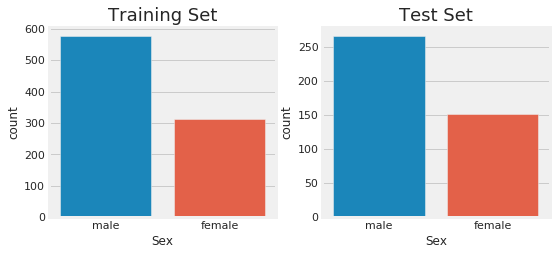

In [7]:
categorical_train_test('Sex')

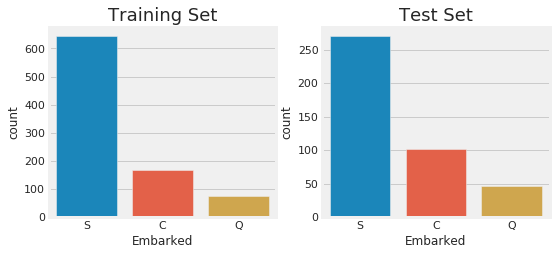

In [8]:
categorical_train_test('Embarked')

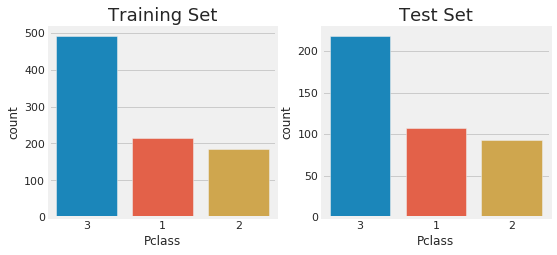

In [9]:
categorical_train_test('Pclass')

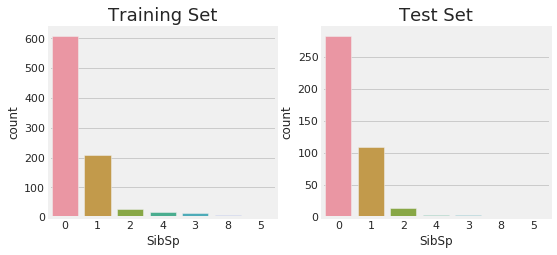

In [10]:
categorical_train_test('SibSp')

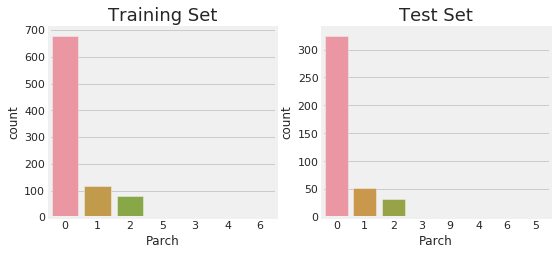

In [11]:
categorical_train_test('Parch')

In [12]:
def continuous_train_test(variable):
    fig, ax = plt.subplots(figsize=(13,3.5))

    sns.distplot(train[variable].dropna(),hist_kws=dict(alpha=0.3), label = 'train')
    sns.distplot(test[variable].dropna(),hist_kws=dict(alpha=0.3), label = 'test')

    plt.legend()
    fig.show()

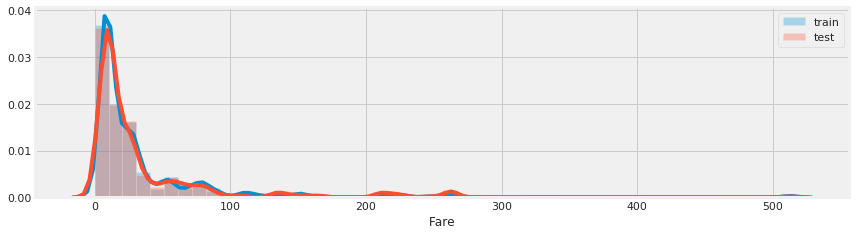

In [13]:
continuous_train_test('Fare')

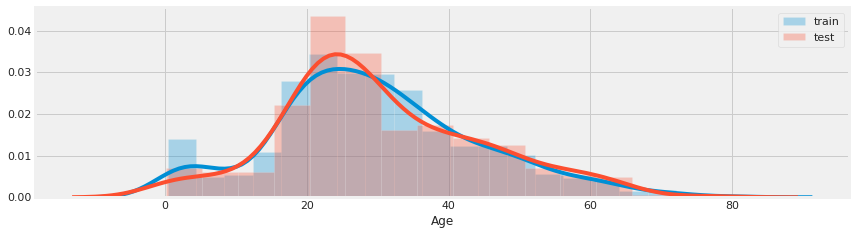

In [14]:
continuous_train_test('Age')

# Building intuition about the data
-Get some domain knowledge to understan the problem in a deeper way that could help to create some insights.  

-Check if the data is intuitive and agrees with our domain knowledge. Otherwise, modify it.  

-**Understand how data was generated.** This can be useful to determine if the validations process is good (check if the train and test set were generated in the same way).

# Creating new variables

Recommended to do it before the NAs are imputed.

First, star by concating train and test. Then, create new variables. Finally, split again the datasets.

In [15]:
# concat train - test
df = pd.concat([test, train])
traindex = train.index
testdex = test.index


In [16]:
# Create new feature FamilySize as a combination of SibSp and Parch
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# variable IsAlone: 1 if a passenger has no family aboard, 0 otherwise.
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone']  = 1

In [17]:
# Length of the ticket
df['Ticket_Len'] = df['Ticket'].apply(lambda x: len(x))

# First character of the ticket code
df['Ticket_first'] = df['Ticket'].apply(lambda x: str(x)[0])

In [18]:
# Length of the name of a passenger
df['Name_Len'] = df['Name'].apply(lambda x: len(x))

# Title of a person
df['Title']=0
df['Title']=df.Name.str.extract('([A-Za-z]+)\.') 

In [19]:
# First character of the cabin code: the ones with n are the NA values
df['Cabin_first'] = df['Cabin'].apply(lambda x: str(x)[0])

In [20]:
#
df['Pclass_Sex'] = df['Pclass'].apply(lambda x: str(x)[0]) + df['Sex']

In [21]:
df['Cabin_is_null'] = 0
df.loc[df['Cabin'].isnull()== True, 'Cabin_is_null']  = 1

In [22]:
# Now that pre-processing is complete, split data into train/test again.
train = df.loc[traindex, :]
train['Survived'] = train['Survived'].apply(lambda x: int(x))

test = df.loc[testdex, :].drop('Survived', axis = 1)

print('The train data has the following dimensions: {}'.format(train.shape))

print('Meanwhile, the test data has the following dimensions: {}'.format(test.shape))

The train data has the following dimensions: (891, 20)
Meanwhile, the test data has the following dimensions: (418, 19)


In [23]:
train.sample(5)

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,FamilySize,IsAlone,Ticket_Len,Ticket_first,Name_Len,Title,Cabin_first,Pclass_Sex,Cabin_is_null
PassengerId,,,,,,,,,,,,,,,,,,,,
110,NaN,NaN,Q,24.150,"Moran, Miss. Bertha",0,3,female,1,1,371110,2,0,6,3,19,Miss,n,3female,1
233,59.0,NaN,S,13.500,"Sjostedt, Mr. Ernst Adolf",0,2,male,0,0,237442,1,1,6,2,25,Mr,n,2male,1
148,9.0,NaN,S,34.375,"Ford, Miss. Robina Maggie ""Ruby""",2,3,female,2,0,W./C. 6608,5,0,10,W,32,Miss,n,3female,1
63,45.0,C83,S,83.475,"Harris, Mr. Henry Birkhardt",0,1,male,1,0,36973,2,0,5,3,27,Mr,C,1male,0
747,16.0,NaN,S,20.250,"Abbott, Mr. Rossmore Edward",1,3,male,1,0,C.A. 2673,3,0,9,C,27,Mr,n,3male,1


# EDA. Explore the new variables


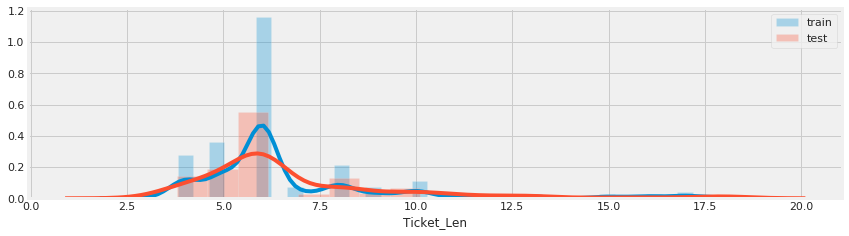

In [24]:
continuous_train_test('Ticket_Len')

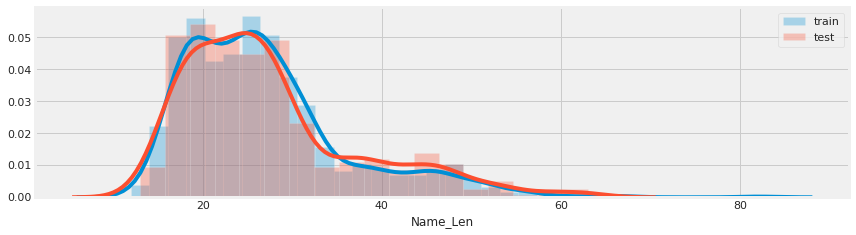

In [25]:
continuous_train_test('Name_Len')

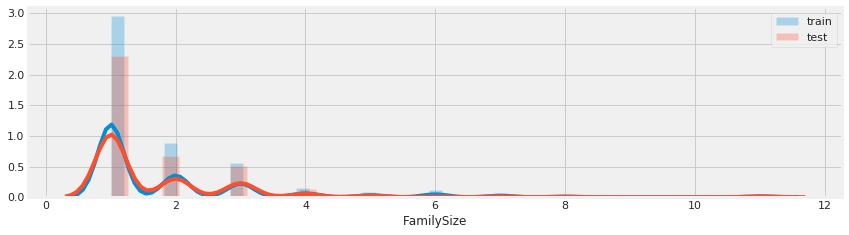

In [26]:
continuous_train_test('FamilySize')

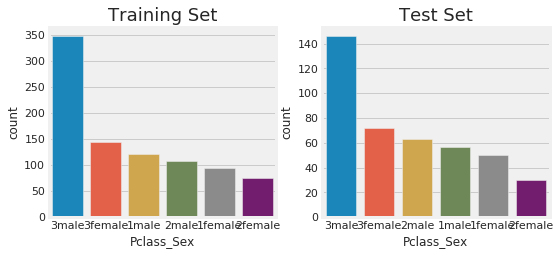

In [27]:
categorical_train_test('Pclass_Sex')

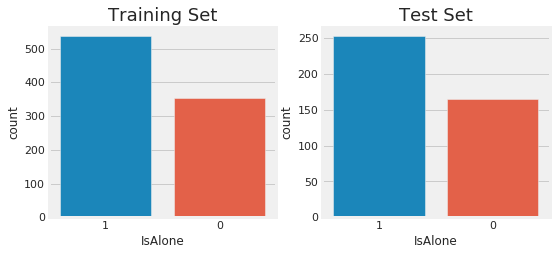

In [28]:
categorical_train_test('IsAlone')

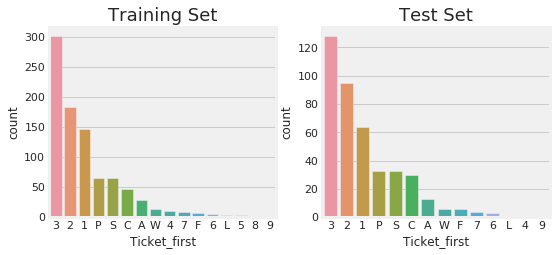

In [29]:
categorical_train_test('Ticket_first')

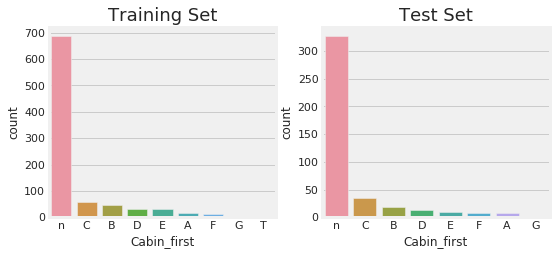

In [30]:
categorical_train_test('Cabin_first')

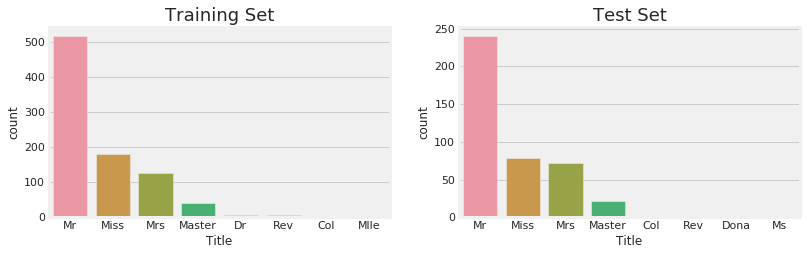

In [31]:
    fig, ax = plt.subplots(figsize=(12,3.5),ncols=2)
    
    ax1 = sns.countplot(x='Title', data=train, ax = ax[0],
                       order = train['Title'].value_counts().head(8).index);
    ax2 = sns.countplot(x='Title', data=test, ax = ax[1],
                       order = test['Title'].value_counts().head(8).index);
    ax1.set_title("Training Set", fontsize = 18)
    ax2.set_title('Test Set',  fontsize = 18)
    
    fig.show()

# EDA. Try to detect which variables have effects on the target

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 20 columns):
Age              714 non-null float64
Cabin            204 non-null object
Embarked         889 non-null object
Fare             891 non-null float64
Name             891 non-null object
Parch            891 non-null int64
Pclass           891 non-null int64
Sex              891 non-null object
SibSp            891 non-null int64
Survived         891 non-null int64
Ticket           891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int64
Ticket_Len       891 non-null int64
Ticket_first     891 non-null object
Name_Len         891 non-null int64
Title            891 non-null object
Cabin_first      891 non-null object
Pclass_Sex       891 non-null object
Cabin_is_null    891 non-null int64
dtypes: float64(2), int64(9), object(9)
memory usage: 186.2+ KB


In [33]:
def create_df_variable_importance(variable):
    if type(variable) == str:
        dataframe = pd.DataFrame({'Mean survival': train['Survived'].groupby(train[variable]).mean(), 
                  'Count': train[variable].value_counts() }).sort_values(by=['Mean survival', 'Count'], ascending=False)
    else: # variables cut with pd.qcut
        dataframe = pd.DataFrame({'Mean survival': train['Survived'].groupby(variable).mean(), 
                  'Count': variable.value_counts() }).sort_values(by=['Mean survival', 'Count'], ascending=False)
    print(dataframe)

create_df_variable_importance('Title')

          Mean survival  Count
Mlle           1.000000      2
Countess       1.000000      1
Lady           1.000000      1
Mme            1.000000      1
Ms             1.000000      1
Sir            1.000000      1
Mrs            0.792000    125
Miss           0.697802    182
Master         0.575000     40
Col            0.500000      2
Major          0.500000      2
Dr             0.428571      7
Mr             0.156673    517
Rev            0.000000      6
Capt           0.000000      1
Don            0.000000      1
Jonkheer       0.000000      1


In [34]:
create_df_variable_importance('Sex')

        Mean survival  Count
female       0.742038    314
male         0.188908    577


In [35]:
create_df_variable_importance('Pclass')

   Mean survival  Count
1       0.629630    216
2       0.472826    184
3       0.242363    491


In [36]:
create_df_variable_importance('FamilySize')

    Mean survival  Count
4        0.724138     29
3        0.578431    102
2        0.552795    161
7        0.333333     12
1        0.303538    537
5        0.200000     15
6        0.136364     22
11       0.000000      7
8        0.000000      6


In [37]:
create_df_variable_importance('Cabin_first')

   Mean survival  Count
D       0.757576     33
E       0.750000     32
B       0.744681     47
F       0.615385     13
C       0.593220     59
G       0.500000      4
A       0.466667     15
n       0.299854    687
T       0.000000      1


In [38]:
create_df_variable_importance(pd.qcut(train['Age'],5))

               Mean survival  Count
(0.419, 19.0]       0.481707    164
(31.8, 41.0]        0.437500    144
(25.0, 31.8]        0.393701    127
(41.0, 80.0]        0.373239    142
(19.0, 25.0]        0.328467    137


In [39]:
create_df_variable_importance('Embarked')

   Mean survival  Count
C       0.553571    168
Q       0.389610     77
S       0.336957    644


In [40]:
create_df_variable_importance('Cabin_is_null')

   Mean survival  Count
0       0.666667    204
1       0.299854    687


In [41]:
train.pivot_table('Survived', index='Sex', columns='Pclass')

Pclass,1,2,3
Sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


# NAs

Not obtained from the course, but from public kernels

In [42]:
# display the % of NA values in each variable
def check_NA_values(df):
    percentage = round(df.isnull().sum().sort_index()/len(df)*100,2).sort_values(ascending = False)
    count = df.isnull().sum().sort_index().sort_values(ascending = False)
    output = pd.concat([count, percentage], axis = 1,keys= ['Total', 'Percent'])
    print(output)

In [43]:
check_NA_values(train)
print('-'*30)
check_NA_values(test)

               Total  Percent
Cabin            687    77.10
Age              177    19.87
Embarked           2     0.22
Ticket_first       0     0.00
Cabin_first        0     0.00
Cabin_is_null      0     0.00
FamilySize         0     0.00
Fare               0     0.00
IsAlone            0     0.00
Name               0     0.00
Title              0     0.00
Parch              0     0.00
Pclass             0     0.00
Pclass_Sex         0     0.00
Sex                0     0.00
SibSp              0     0.00
Survived           0     0.00
Ticket             0     0.00
Ticket_Len         0     0.00
Name_Len           0     0.00
------------------------------
               Total  Percent
Cabin            327    78.23
Age               86    20.57
Fare               1     0.24
Name               0     0.00
Cabin_first        0     0.00
Cabin_is_null      0     0.00
Embarked           0     0.00
FamilySize         0     0.00
IsAlone            0     0.00
Title              0     0.00
Ticket_fi

### Embarked in train


In [44]:
train.Embarked.fillna("C",inplace = True)

### Fare in test

In [45]:
Fare_by_class = test.groupby("Pclass").Fare.mean()
test.Fare.fillna(Fare_by_class[3], inplace=True)
del Fare_by_class

## train-test NA imputation

In [46]:
# concat train - test
df = pd.concat([test, train])
traindex = train.index
testdex = test.index

In [47]:
def age_imputer(i):
    age = 0
    if i.Pclass == 1 and i.Sex == "female":
        age = 37
    elif i.Pclass == 1 and i.Sex == "male":
        age = 41
    elif i.Pclass == 2 and i.Sex == "female":
        age = 27
    elif i.Pclass == 2 and i.Sex == "male":
        age = 31
    elif i.Pclass == 3 and i.Sex == "female":
        age = 22
    elif i.Pclass == 3 and i.Sex == "male":
        age = 26
    return age

In [48]:
without_age = df[df.Age.isnull()]
with_age = df[df.Age.isnull() == False]

without_age['Age'] = without_age.apply(age_imputer, axis=1)

## getting back train data
df = pd.concat([with_age, without_age], axis=0)

## PassengerId helps us separate train and test. 
df.sort_values(by = 'PassengerId', inplace=True)




In [49]:
# drop Cabin
df = df.drop("Cabin", axis = 1)

# Encoding
Before separating df back into train & test, let us first encode the categorical variables.

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 19 columns):
Age              1309 non-null float64
Cabin_first      1309 non-null object
Cabin_is_null    1309 non-null int64
Embarked         1309 non-null object
FamilySize       1309 non-null int64
Fare             1309 non-null float64
IsAlone          1309 non-null int64
Name             1309 non-null object
Name_Len         1309 non-null int64
Parch            1309 non-null int64
Pclass           1309 non-null int64
Pclass_Sex       1309 non-null object
Sex              1309 non-null object
SibSp            1309 non-null int64
Survived         891 non-null float64
Ticket           1309 non-null object
Ticket_Len       1309 non-null int64
Ticket_first     1309 non-null object
Title            1309 non-null object
dtypes: float64(3), int64(8), object(8)
memory usage: 204.5+ KB


In [51]:
categorical_variables = df.select_dtypes(include=['object']).columns.tolist()
categorical_variables

['Cabin_first',
 'Embarked',
 'Name',
 'Pclass_Sex',
 'Sex',
 'Ticket',
 'Ticket_first',
 'Title']

In [52]:
df = pd.get_dummies(df, columns=categorical_variables )

# Get back train-test and check if the NAs were removed

In [53]:
# Now that pre-processing is complete, split data into train/test again.
train = df.loc[traindex, :]
train['Survived'] = train['Survived'].apply(lambda x: int(x))

test = df.loc[testdex, :].drop('Survived', axis = 1)

print('The train data has the following dimensions: {}'.format(train.shape))

print('Meanwhile, the test data has the following dimensions: {}'.format(test.shape))

The train data has the following dimensions: (891, 2301)
Meanwhile, the test data has the following dimensions: (418, 2300)


In [54]:
check_NA_values(train)
print('-'*30)
check_NA_values(test)


                                                    Total  Percent
Title_Sir                                               0      0.0
Name_Makinen, Mr. Kalle Edvard                          0      0.0
Name_Mangan, Miss. Mary                                 0      0.0
Name_Mamee, Mr. Hanna                                   0      0.0
Name_Mallet, Mrs. Albert (Antoinette Magnin)            0      0.0
Name_Mallet, Mr. Albert                                 0      0.0
Name_Mallet, Master. Andre                              0      0.0
Name_Malachard, Mr. Noel                                0      0.0
Name_Maisner, Mr. Simon                                 0      0.0
Name_Mannion, Miss. Margareth                           0      0.0
Name_Maioni, Miss. Roberta                              0      0.0
Name_Mahon, Mr. John                                    0      0.0
Name_Mahon, Miss. Bridget Delia                         0      0.0
Name_Maguire, Mr. John Edward                           0     

# Modeling

In [55]:
# separate target (y) and data (X)
y = train['Survived']
X = train.drop('Survived', axis =1)

# check
print(train.shape)
print(X.shape)
print(y.shape)

(891, 2301)
(891, 2300)
(891,)


Cross - validation strategy:

As the amount of data available is quite small, we should opt for a leave-one-out validation schema.

In [56]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

# model definition
rf = RandomForestClassifier()

# loov
loo = LeaveOneOut()
scores = cross_val_score(rf, X, y, cv=loo, verbose = 1)
print("Number of cv iterations: ", len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Number of cv iterations:  891
Mean accuracy: 0.82


[Parallel(n_jobs=1)]: Done 891 out of 891 | elapsed:  1.3min finished


This had a long run time given how small the dataset is. We can also try with the K-fold validation with 10 folds:

In [57]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits = 10)
print("Cross-validation scores:\n{}".format(cross_val_score(rf, X, y, cv=kfold)))
print("Number of cv iterations: ", len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))

Cross-validation scores:
[0.78888889 0.88764045 0.76404494 0.86516854 0.83146067 0.86516854
 0.78651685 0.83146067 0.86516854 0.83146067]
Number of cv iterations:  891
Mean accuracy: 0.82


Run time was highly reduced.

# Split the train dataset
Split it into the train and test train (test_tr) datasets.


In [58]:
X_train, X_test_tr, y_train, y_test_tr = train_test_split(
X, y, random_state=0)

# Grid Search using Cross Validation

In [59]:
from sklearn.model_selection import GridSearchCV

# define the grid
param_grid =  {'n_estimators':[50,100,300,500,700], 'max_depth': [10,15,20,25,30], 
               'max_features': [5,10,15,20,25]}

#instantiate the gridsearch class
grid_search = GridSearchCV(rf, param_grid, cv=5)

In [60]:
# fit the class to the training data
grid_search.fit(X_train, y_train) # the most time consuming task

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [61]:
print("Test set score: {:.2f}".format(grid_search.score(X_test_tr, y_test_tr)))
print('-'*30)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print('-'*30)
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Test set score: 0.83
------------------------------
Best parameters: {'max_depth': 30, 'max_features': 15, 'n_estimators': 50}
Best cross-validation score: 0.83
------------------------------
Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features=15, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [62]:
best_rf = grid_search.best_estimator_ # store the best model
best_rf.fit(X, y) # fit it to the entire competition train set

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features=15, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [63]:
sample_submission = pd.DataFrame({
    'PassengerId': test.index,
    'Survived': best_rf.predict(test)
})
sample_submission.to_csv('gridsearch_tuned_RF.csv', index=False)

# XGBoost

In [64]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

xgb_clf = xgb.XGBClassifier(missing=-999)

# Create a dictionary of hyperparameters to search
param_grid = {'n_estimators':[100,200,300], 'max_depth': [5,10,15], 
        'learning_rate': [0.02,0.04,0.06]}

#instantiate the gridsearch class
rnd_search_cv = RandomizedSearchCV(xgb_clf, param_grid, n_iter=10, cv=5)



In [65]:
# fit the class to the training data
rnd_search_cv.fit(X_train, y_train) # the most time consuming task

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=-999, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
          

In [66]:
print("Test set score: {:.2f}".format(rnd_search_cv.score(X_test_tr, y_test_tr)))
print('-'*30)
print("Best parameters: {}".format(rnd_search_cv.best_params_))
print("Best cross-validation score: {:.2f}".format(rnd_search_cv.best_score_))
print('-'*30)
print("Best estimator:\n{}".format(rnd_search_cv.best_estimator_))

Test set score: 0.83
------------------------------
Best parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.02}
Best cross-validation score: 0.83
------------------------------
Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=-999, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [67]:
best_xgb = rnd_search_cv.best_estimator_ # store the best model
best_xgb.fit(X, y) # fit it to the entire competition train set

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=-999, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [68]:
sample_submission = pd.DataFrame({
    'PassengerId': test.index,
    'Survived': best_xgb.predict(test)
})
sample_submission.to_csv('randomizedsearch_tuned_xgb.csv', index=False)

In [69]:
from sklearn.ensemble import VotingClassifier
blend = VotingClassifier(estimators=[('tunedRF', best_RF), 
                                     ('tunedXGB', best_xgb)], 
                         voting='hard')


# scores = cross_val_score(blend, X_train, y_train, cv=kfold)
# scores_mean = scores.mean()
# scores_std = scores.std()
# print("Cross-validation scores for VotingClf:\n{} +/- {}.".format(scores_mean, scores_std))

blend.fit(X_train,y_train)

print("Accuracy on validation set {}".format(accuracy_score(y_test_tr, clf.predict(X_test_tr))))

NameError: name 'best_RF' is not defined

In [70]:
sample_submission = pd.DataFrame({
    'PassengerId': test.index,
    'Survived': blend.predict(test)
})
sample_submission.to_csv('voting.csv', index=False)

NameError: name 'blend' is not defined